<a href="https://colab.research.google.com/github/Sharkar96/BHDQN/blob/main/BHDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import random as r
import numpy as np
import math as m
from numpy import linalg
from shapely.geometry import Point, Polygon, LineString
from shapely import affinity, distance
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
np.set_printoptions(precision=5)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
def point2nparray(p: Point):
  return np.array([p.x, p.y])

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

maxDivision=10

def divide(n, d):
  return min(n / d, maxDivision) if d else maxDivision

Parameters

In [15]:
katt=1 #attraction coefficient
kstr=8 #blackhole field coefficient
krep=20 #repulsive coefficient
delta=1 #safety distance
delta0=4 #range of repulsive field
ps=8 #range of blackhole field
W1=-100 #collision penalty
W2=10 #reward of completing goals
W3=-0.2 #penalty for each time
alpha=-80 #reward coefficient of potential field
gamma=0.95 #discount rate
ts=1 #sampling time
eps=2 #distance from the goal to be reached
stdDev=0.1 #standard deviation for the gaussian noise

In [16]:
class Obstacle:
  def __init__(self, o: Point, A):
    self.A=A
    self.o=o
    self.obstacle=None
    self.createObstacle(o, A)

  def contains(self, *arg):
    return self.obstacle.contains(arg)

  def createObstacle(self, o: Point, A):
    th=360*r.random()
    rngLength=(r.random()+0.5)*m.sqrt(A)

    vertex=[]
    vertex.append(Point(o.x-rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y+(A/rngLength)/2))
    vertex.append(Point(o.x-rngLength/2,o.y+(A/rngLength)/2))

    self.obstacle=affinity.rotate(Polygon(vertex),th)

  def polygon2array(self):
    x,y =self.obstacle.exterior.coords.xy
    return[list(a) for a in zip(x,y)]

  def __str__(self):
    return str(self.obstacle)

In [17]:
class Robot:
  def __init__(self, x, y):
    self.x=x
    self.y=y
    #moves: E, NE, N, NW, W, SW, S, SE
    self.moves=['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
    self.possibleMoves= np.array([[1,0],
                             [0.707,0.707],
                             [0,1],
                             [-0.707,0.707],
                             [-1,0],
                             [-0.707,-0.707],
                             [0,-1],
                             [0.707,-0.707]]
                            )

  def compass(self, force):
    return np.dot(force, self.possibleMoves.T)

  def move(self, chosenMove, verbose=False):
    self.x=self.x + np.random.normal(0, stdDev) + ts*self.possibleMoves[chosenMove][0]
    self.y=self.y + np.random.normal(0, stdDev) + ts*self.possibleMoves[chosenMove][1]

    if verbose:
      print(self.moves[chosenMove], end=' ')
      print(np.array([self.x, self.y]))
    return

  def __str__(self):
    return str(np.array([self.x,self.y]))

In [6]:
class Maze:
  def __init__(self, A):
    self.l=m.sqrt(A)
    self.coordinates=np.array([[0,0],
                              [self.l,0],
                              [self.l,self.l],
                              [0,self.l]])
    self.obstacles=[]
    self.goals=[]
    self.robot=None
    self.Umin= -0.5*kstr*ps**2
    self.Umax= 0.5*krep*(maxDivision-1/4)**2  #+ 0.5*katt*(self.l*1.41)**2

  def getState(self, stateSize=9):
    p= np.array([self.robot.x,self.robot.y])
    state= np.zeros((stateSize, stateSize))
    for i in range(stateSize):
      for j in range(stateSize):
        state[i, j]=self.potentialField(p+np.array([j-(stateSize-1)/2,i-(stateSize-1)/2]))

    return np.flipud(state)

  def step(self, action):
    def calcReward(pt1, pt2):
      reward=0
      if maze.robot.x <0 or maze.robot.x>self.l or maze.robot.y <0 or maze.robot.y>self.l or self.isGoalOccluded(Point(maze.robot.x, maze.robot.y)):
        reward+=W1
      if self.isGoalReached():
        reward+=W2
      reward+=W3
      reward+=alpha*(pt2-pt1)
      return reward

    pt1=self.potentialField()
    self.robot.move(action)
    pt2=self.potentialField()
    nextState=self.getState(stateSize)
    reward=calcReward(pt1, pt2)
    done=self.isGoalReached()
    return nextState, reward, done

  def potentialField(self, p=None):
    if p is None:
      p=np.array([self.robot.x, self.robot.y])

    #check if the point is inside an obstacle enlarged by delta
    for i in self.obstacles:
      if i.obstacle.buffer(delta, join_style=2).contains(Point(p[0],p[1])):
        return 1

    resultingP=0
    for i in self.goals:
      dis=distance(i, Point(p[0], p[1]))
      #attractive potential
      normalAttP= katt*0.5*(dis)**2

      #black hole potential
      blackHolePmodule=0
      if dis <= ps:
        blackHolePmodule=-0.5*kstr*(ps-dis)**2
      resultingP = resultingP + normalAttP + blackHolePmodule

    #repulsive potential
    for i in self.obstacles:
      dis=distance(i.obstacle, Point(p[0], p[1]))
      repulsiveP=0
      if dis <= delta0:
        repulsiveP=0.5*krep*(divide(1,dis-delta)-divide(1,delta0-delta))**2
      resultingP = resultingP + repulsiveP

    #normalize
    resultingP=(resultingP-self.Umin)/(self.Umax-self.Umin)
    return resultingP

  def gravitationalForce(self, p=None):
    if p is None:
      p=np.array([self.robot.x, self.robot.y])

    resultingF=np.array([0, 0])
    for i in self.goals:
      #attractive force
      normalAttF= -katt*(p - point2nparray(i))

      #black hole force
      dis=distance(i, Point(p[0], p[1]))
      blackHoleF=np.array([0, 0])
      if dis <= ps:
        blackHoleFmodule= kstr*(ps-dis)
        blackHoleF=blackHoleFmodule*normalize(point2nparray(i)-p)
      resultingF = resultingF + normalAttF + blackHoleF

    #repulsive force
    for i in self.obstacles:
      dis=distance(i.obstacle, Point(p[0], p[1]))
      repulsiveF= np.array([0, 0])
      if dis <= delta0:
        repulsiveFmodule=-krep*(divide(1,dis-delta)-divide(1,delta0-delta))*divide(1,(dis-delta)**2)
        p1, p2 = nearest_points(i.obstacle, Point(p[0], p[1]))
        repulsiveF=-repulsiveFmodule*normalize(point2nparray(p2)-point2nparray(p1))
      resultingF = resultingF + repulsiveF
    return resultingF

  #it assumes just 1 robot
  def isGoalReached(self):
    robotPosition= np.array([self.robot.x, self.robot.y])
    for goal in self.goals:
      if linalg.norm(point2nparray(goal)-robotPosition)<=eps:
        return True

    return False

  #check if a goal spawned inside an obstacle
  def isGoalOccluded(self, p: Point):
    for i in self.obstacles:
      if i.contains(p):
        return True
    return False

  #check if the obstacle spawned over a goal
  def isObstacleOccluding(self, p: Polygon):
    for i in self.goals:
      if p.contains(i):
        return True
    return False

  #spawnRobot must be performed after add Obstacles
  def spawnRobot(self, x=None, y=None):
      if x is not None and y is not None:
        if self.isGoalOccluded(Point(x,y)):
          print('Position was eccupied')
        else:
          self.robot=Robot(x,y)
          return

      candidate=Point(r.random()*self.l,r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l,r.random()*self.l)
      self.robot=Robot(candidate.x,candidate.y)

  #addGoals and addObstacles can be performed in every order
  def addGoals(self,n=1):
    for i in range(n):
      candidate=Point(r.random()*self.l, r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l, r.random()*self.l)
      self.goals.append(candidate)

  def addObstacles(self, n=1):
    #maximum area is 7% of entire maze
    maxA=0.07
    for i in range(n):
      candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      while self.isObstacleOccluding(candidate):
        candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      self.obstacles.append(candidate)

  def print(self):
    print('coordinates: '+ str(self.coordinates))
    print('-------------------')
    print('robot: ' + str(self.robot))
    print('-------------------')
    print('goals: ')
    for i in self.goals:
      print(point2nparray(i))
    print('-------------------')
    print('obstacles: ')
    for i in self.obstacles:
      print(i)
    print('-------------------')
    print('Umin: ' + str(self.Umin))
    print('Umax: ' + str(self.Umax))
    print('-------------------')

  def plot(self):
    plt.clf()
    #plot the maze
    rectangle = patches.Rectangle((0,0), self.l, self.l,
                              linewidth=1, edgecolor='b', facecolor='none')
    plt.gca().add_patch(rectangle)
    #plot robot
    plt.scatter(self.robot.x, self.robot.y, c='b', marker='o', label='Robot')
    #plot goals
    for goal in self.goals:
         circle= patches.Circle((goal.x, goal.y), eps, edgecolor='g', facecolor='lightgreen', linestyle='--')
         plt.gca().add_patch(circle)
         circle= patches.Circle((goal.x, goal.y), ps, edgecolor='black', facecolor='none',linestyle='--', label='blackhole')
         plt.gca().add_patch(circle)
         plt.scatter(goal.x, goal.y, color='darkgreen', marker='x', label='Goal')
    #plot obstacles
    for obs in self.obstacles:
      poly=patches.Polygon(obs.polygon2array(),edgecolor='r', facecolor='r')
      plt.gca().add_patch(poly)
    plt.gca().set_aspect('equal')
    plt.xticks(range(0, m.ceil(self.l),4))
    plt.yticks(range(0, m.ceil(self.l),4))
    plt.xlim(-1, m.ceil(self.l)+1)
    plt.ylim(-1, m.ceil(self.l)+1)
    plt.legend()
    plt.draw()
    plt.pause(0.1)


In [18]:
def buildMaze(area=2500, nGoals=1, xRobot=None, yRobot=None, nObstacles=0):
  maze=Maze(2500)
  maze.addGoals(nGoals)
  maze.spawnRobot(xRobot, yRobot)
  maze.addObstacles(nObstacles)
  return maze

**QN**

In [19]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import Adam

In [20]:
stateSize = 9  # 2D environment, assuming x and y coordinates
nActions = 8  # 8 possible moves
ReLUalpha = 0.1
learningRate=0.1 #for Adam
maxEpochs=80

In [21]:
def buildQN(inputShape, nActions):
  model = Sequential()

  model.add(Conv2D(16, (3, 3), padding='same', input_shape=inputShape))
  model.add(LeakyReLU(alpha=ReLUalpha))
  model.add(Conv2D(16, (3, 3), padding='same'))
  model.add(LeakyReLU(alpha=ReLUalpha))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  # Fully connected layers
  model.add(Dense(32))
  model.add(LeakyReLU(alpha=ReLUalpha))
  model.add(Dense(32))
  model.add(LeakyReLU(alpha=ReLUalpha))

  # Output layer
  model.add(Dense(nActions, activation='linear'))

  # Compile the model
  model.compile(loss='mse', optimizer=Adam(learning_rate=learningRate))
  return model

QN = buildQN((stateSize, stateSize, 1), nActions)
#QN.summary()

episode: 0/10
cumulative reward: -12.12808433817607
episode: 1/10
cumulative reward: 3.1118915570858006
episode: 2/10
cumulative reward: -20.315352177007597
episode: 3/10
cumulative reward: -29.43530623026393
episode: 4/10
cumulative reward: -29.62699442760307
episode: 5/10
cumulative reward: -23.270488149714726
episode: 6/10
cumulative reward: -11.716463678514698
episode: 7/10
cumulative reward: -23.50232568695607
episode: 8/10
cumulative reward: -14.473377358100258
episode: 9/10
cumulative reward: -21.260734696836465


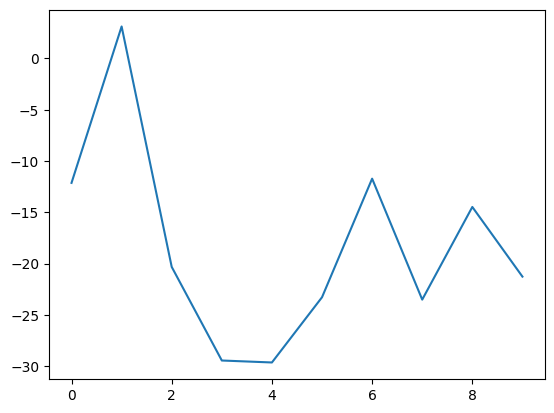

In [24]:
QN.load_weights('/content/drive/MyDrive/Colab Notebooks/q_network_weights.h5')


def pipeline(QN, nEpisodes, epsilon, nObstacles):
  maze=buildMaze()
  #plt.ion()
  episodesRewards=[]
  for episode in range(nEpisodes):
    print('episode: ' + str(episode) + '/' + str(nEpisodes))

    # Initialize the environment and get the initial state
    state = maze.getState(stateSize).reshape((1,stateSize,stateSize,1))
    done = maze.isGoalReached()

    cumulativeReward=0
    loss=[]
    i=0
    while not done and i<maxEpochs :
        i+=1
        #epsilon-greedy strategy
        if np.random.rand() < epsilon:
            action = np.random.randint(nActions)
        else:
            qValues = QN.predict(state, verbose=0)
            action = np.argmax(qValues)

        #performes the action chosen by the current QN
        nextState, reward, done = maze.step(action)
        cumulativeReward+=reward
        #maze.plot()
        target = reward + gamma * np.max(QN.predict(nextState.reshape((1,stateSize,stateSize,1)),verbose=0))
        qValues = QN.predict(state, verbose=0)
        qValues[0, action] = target

        #Train the Q-network on the updated Q-values
        history=QN.fit(state, qValues, verbose=0)
        loss.append(history.history['loss'][0])

    print('cumulative reward: ' + str(cumulativeReward))
    episodesRewards.append(cumulativeReward)
    #plt.plot(loss)
    maze.spawnRobot()
    #plt.ioff()
    #plt.show()

  QN.save_weights('/content/drive/MyDrive/Colab Notebooks/q_network_weights.h5')
  plt.plot(episodesRewards)


pipeline(QN,10,0.90,0)

For using the newly trained QN

In [ ]:
maze=buildMaze()
maze.plot()


In [ ]:
epochs=10
plt.ion()
for epoch in range(epochs):
  if maze.isGoalReached():
    print('the goal was reached')
    break
  else:
    state= maze.robot.compass(maze.gravitationalForce())
    print(state)
    qvalues=QN.predict(state.reshape(1, -1))
    print(qvalues)
    chosenMove= np.argmax(qvalues)
    print(maze.robot.moves[chosenMove])
    maze.robot.move(chosenMove)
    maze.plot()

plt.ioff()
plt.show()

Old code: just the APF

In [ ]:
#for testing the first part of the program
maze=Maze(2500)
maze.addGoals(1)
maze.addObstacles(0)
maze.spawnRobot()
maze.print()
maze.plot()


In [ ]:
#for testing the first part of the program

epochs=100
plt.ion()
for epoch in range(epochs):
  if maze.isGoalReached():
    print('the goal was reached')
    break
  else:
    chosenMove= np.argmax(maze.robot.compass(maze.gravitationalForce()))
    print(maze.getState(3))
    maze.robot.move(chosenMove)
    maze.plot()

plt.ioff()
plt.show()
